NOTE: Most of the original code for this project has been overwritten by the code found [here](https://www.tensorflow.org/tutorials/generative/cvae)

In [ ]:
# encoder = keras.Sequential([
#         keras.layers.InputLayer(input_shape=(28, 28, 1)),
#         keras.layers.Conv2DTranspose(
#             filters=128, kernel_size=3, strides=1, padding='same',
#             activation='leaky_relu'),  
#         keras.layers.Conv2D(
#             filters=256, kernel_size=3, strides=(2, 2), activation='tanh'),
#         keras.layers.Conv2D(
#             filters=512, kernel_size=3, strides=(2, 2), activation='tanh'),
#         keras.layers.Flatten(), # For logits
#         # No activation
#         keras.layers.Dense(X+X),
#     ]
# )

# decoder = keras.Sequential([
#         keras.layers.InputLayer(input_shape=(X,)),
#         keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
#         keras.layers.Reshape(target_shape=(7, 7, 32)),
#         keras.layers.Conv2DTranspose(
#             filters=512, kernel_size=3, strides=1, padding='same',
#             activation='tanh'),
#         keras.layers.Conv2DTranspose(
#             filters=256, kernel_size=3, strides=1, padding='same',
#             activation='tanh'),
#         keras.layers.Conv2DTranspose(
#             filters=128, kernel_size=3, strides=1, padding='same',
#             activation='leaky_relu'),    
#         # No activation
#         keras.layers.Conv2DTranspose(
#             filters=1, kernel_size=3, strides=1, padding='same'),
#     ]
# )

In [39]:
# Add dependencies
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [41]:
from IPython import display

import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import time

TRAIN_SIZE = 60000
BATCH_SIZE = 32
TEST_SIZE = 10000
OPTIMIZER = tf.keras.optimizers.Adam(1e-4)
EPOCHS = 10
LATENT_DIM = 2 # set the dimensionality of the latent space to a plane for visualization later

In [42]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

# Get data
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

# Process imgs
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(TRAIN_SIZE).batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(TEST_SIZE).batch(BATCH_SIZE))

#### CVAE Model Architecture

In [43]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=128, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

#### Optimization and Loss

In [45]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

#### Set Up Testing

In [46]:
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, LATENT_DIM])
model = CVAE(LATENT_DIM)

In [47]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [48]:
# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

#### Training and Evaluation

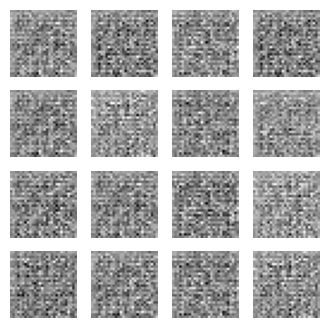

KeyboardInterrupt: 

In [49]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, EPOCHS + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, OPTIMIZER)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}\n Test set ELBO: {}\n Time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)
